In [1]:
# this is certified!
import argparse
import os
import pprint

import gymnasium as gym
import numpy as np
import torch
from torch.utils.tensorboard import SummaryWriter

from LCRL.env import DummyVectorEnv
from LCRL.exploration import GaussianNoise
from LCRL.utils.net.common import Net
from LCRL.utils.net.continuous import Actor, Critic
import LCRL.reach_rl_gym_envs as reach_rl_gym_envs
# NOTE: all the reach-avoid gym environments are in reach_rl_gym, the constraint information is output as an element of the info dictionary in gym.step() function

# NOTE: This notebook is used after training the classical reach-avoid value function via DDPG


"""
    We can also learn learn the classical reach-avoid value function by using DDPG under the classical annealed reach-avoid Bellman equation in arXiv:2112.12288:
    python run_training_ddpg.py --task ra_highway_Game-v2 --control-net 512 512 512 --disturbance-net 512 512 512 --critic-net 512 512 512 --gamma 0.95 --epoch 10 --total-episodes 160 --is-game-baseline True
"""
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--task', type=str, default='ra_highway_Game-v2')
    parser.add_argument('--reward-threshold', type=float, default=None)
    parser.add_argument('--seed', type=int, default=0) 
    parser.add_argument('--buffer-size', type=int, default=40000)
    parser.add_argument('--actor-lr', type=float, default=1e-4)
    parser.add_argument('--critic-lr', type=float, default=1e-3)
    parser.add_argument('--gamma', type=float, default=0.95) # 0.95, 1580
    parser.add_argument('--tau', type=float, default=0.005)
    parser.add_argument('--exploration-noise', type=float, default=0.1)
    parser.add_argument('--epoch', type=int, default=10)
    parser.add_argument('--total-episodes', type=int, default=160)
    parser.add_argument('--step-per-epoch', type=int, default=40000)
    parser.add_argument('--step-per-collect', type=int, default=8)
    parser.add_argument('--update-per-step', type=float, default=0.125)
    parser.add_argument('--batch-size', type=int, default=512)
    parser.add_argument('--control-net', type=int, nargs='*', default=[512, 512, 512]) # for control policy
    parser.add_argument('--disturbance-net', type=int, nargs='*', default=[512, 512, 512]) # for disturbance policy
    parser.add_argument('--critic-net', type=int, nargs='*', default=[512, 512, 512]) # for critic net
    parser.add_argument('--training-num', type=int, default=8)
    parser.add_argument('--test-num', type=int, default=100)
    parser.add_argument('--logdir', type=str, default='log')
    parser.add_argument('--render', type=float, default=0.)
    parser.add_argument('--rew-norm', action="store_true", default=False)
    parser.add_argument('--n-step', type=int, default=1)
    parser.add_argument('--continue-training-logdir', type=str, default=None)
    parser.add_argument('--continue-training-epoch', type=int, default=None)
    parser.add_argument('--actor-gradient-steps', type=int, default=1)
    parser.add_argument('--is-game-baseline', type=bool, default=True) # True -> baseline, classical annealed reach-avoid Bellman equation; False -> Our new Reach-RL Bellman equation   
    parser.add_argument('--target-update-freq', type=int, default=400)
    parser.add_argument(
        '--device', type=str, default='cuda' if torch.cuda.is_available() else 'cpu'
    )
    parser.add_argument('--actor-activation', type=str, default='ReLU')
    parser.add_argument('--critic-activation', type=str, default='ReLU')
    parser.add_argument('--kwargs', type=str, default='{}')
    args = parser.parse_known_args()[0]
    return args



args=get_args()


env = gym.make(args.task)
args.state_shape = env.observation_space.shape or env.observation_space.n
args.action_shape = env.action_space.shape or env.action_space.n
args.max_action = env.action_space.high[0]

# check if the environment has control and disturbance actions:
assert hasattr(env, 'action1_space') and hasattr(env, 'action2_space'), "The environment does not have control and disturbance actions!"
args.action1_shape = env.action1_space.shape or env.action1_space.n
args.action2_shape = env.action2_space.shape or env.action2_space.n
args.max_action1 = env.action1_space.high[0]
args.max_action2 = env.action2_space.high[0]


# you can also use tianshou.env.SubprocVectorEnv
# train_envs = gym.make(args.task)
train_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.training_num)]
)
# test_envs = gym.make(args.task)
test_envs = DummyVectorEnv(
    [lambda: gym.make(args.task) for _ in range(args.test_num)]
)
# seed
np.random.seed(args.seed)
torch.manual_seed(args.seed)
train_envs.seed(args.seed)
test_envs.seed(args.seed)
# model

if args.actor_activation == 'ReLU':
    actor_activation = torch.nn.ReLU
elif args.actor_activation == 'Tanh':
    actor_activation = torch.nn.Tanh
elif args.actor_activation == 'Sigmoid':
    actor_activation = torch.nn.Sigmoid
elif args.actor_activation == 'SiLU':
    actor_activation = torch.nn.SiLU

if args.critic_activation == 'ReLU':
    critic_activation = torch.nn.ReLU
elif args.critic_activation == 'Tanh':
    critic_activation = torch.nn.Tanh
elif args.critic_activation == 'Sigmoid':
    critic_activation = torch.nn.Sigmoid
elif args.critic_activation == 'SiLU':
    critic_activation = torch.nn.SiLU

if args.critic_net is not None:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.critic_net,
        activation=critic_activation,
        concat=True,
        device=args.device
    )
else:
    critic_net = Net(
        args.state_shape,
        args.action_shape,
        hidden_sizes=args.hidden_sizes,
        activation=critic_activation,
        concat=True,
        device=args.device
    )

critic = Critic(critic_net, device=args.device).to(args.device)
critic_optim = torch.optim.Adam(critic.parameters(), lr=args.critic_lr)

critic1 = Critic(critic_net, device=args.device).to(args.device)
critic1_optim = torch.optim.Adam(critic1.parameters(), lr=args.critic_lr)
critic2 = Critic(critic_net, device=args.device).to(args.device)
critic2_optim = torch.optim.Adam(critic2.parameters(), lr=args.critic_lr)    
if args.control_net is None:
    args.control_net = args.hidden_sizes
if args.disturbance_net is None:
    args.disturbance_net = args.hidden_sizes
if args.critic_net is None:
    args.critic_net = args.hidden_sizes
# import pdb; pdb.set_trace()
log_path = None

if args.is_game_baseline:
    from LCRL.policy import reach_avoid_game_DDPGPolicy_annealing as DDPGPolicy
    print("DDPG under the Reach-Avoid annealed Bellman equation has been loaded!")
else:
    from LCRL.policy import reach_avoid_game_DDPGPolicy as DDPGPolicy
    print("DDPG under Reach-RL Bellman equation has been loaded!")
actor1_net = Net(args.state_shape, hidden_sizes=args.control_net, activation=actor_activation, device=args.device)
actor1 = Actor(
    actor1_net, args.action1_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor1_optim = torch.optim.Adam(actor1.parameters(), lr=args.actor_lr)
actor2_net = Net(args.state_shape, hidden_sizes=args.disturbance_net, activation=actor_activation, device=args.device)
actor2 = Actor(
    actor2_net, args.action2_shape, max_action=args.max_action1, device=args.device
).to(args.device)
actor2_optim = torch.optim.Adam(actor2.parameters(), lr=args.actor_lr)

policy = DDPGPolicy(
critic,
critic_optim,
tau=args.tau,
gamma=args.gamma,
exploration_noise=GaussianNoise(sigma=args.exploration_noise),
reward_normalization=args.rew_norm,
estimation_step=args.n_step,
action_space=env.action_space,
actor1=actor1,
actor1_optim=actor1_optim,
actor2=actor2,
actor2_optim=actor2_optim,
actor_gradient_steps=args.actor_gradient_steps,
)
if args.is_game_baseline:
    log_path = os.path.join(args.logdir, args.task, 'baseline_ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)
else:
    log_path = os.path.join(args.logdir, args.task, 'ddpg_reach_avoid_actor_activation_{}_critic_activation_{}_game_gd_steps_{}_tau_{}_training_num_{}_buffer_size_{}_c_net_{}_{}_a1_{}_{}_a2_{}_{}_gamma_{}'.format(
    args.actor_activation, 
    args.critic_activation, 
    args.actor_gradient_steps,args.tau, 
    args.training_num, 
    args.buffer_size,
    args.critic_net[0],
    len(args.critic_net),
    args.control_net[0],
    len(args.control_net),
    args.disturbance_net[0],
    len(args.disturbance_net),
    args.gamma)
)


log_path = log_path+'/noise_{}_actor_lr_{}_critic_lr_{}_batch_{}_step_per_epoch_{}_kwargs_{}_seed_{}'.format(
        args.exploration_noise, 
        args.actor_lr, 
        args.critic_lr, 
        args.batch_size,
        args.step_per_epoch,
        args.kwargs,
        args.seed
    )



DDPG under the Reach-Avoid annealed Bellman equation has been loaded!


In [2]:
color_list = [
    "#ff910a",  # Original color 1
    "#828282",  # Original color 2
    "#1c9993",  # Original color 3
    "#B4259A",  # Original color 4
    "#B02418",  # Original color 5
    "#99331c",  # New color 1 (Complementary to #1c9993)
    "#ffa50a",  # New color 2 (Analogous to #ff910a)
    "#25B49A",   # New color 3 (Triadic to #B4259A)
    "#4A90E2"
]

In [ ]:
# NOTE! if you want to use the pre-trained model, you can set the path to the model here:
# otherwise, you can skip this cell and move to the next cell
log_path = "pretrained_neural_networks/ra_highway_Game-v2/baseline_ddpg_reach_avoid_actor_activation_ReLU_critic_activation_ReLU_game_gd_steps_1_tau_0.005_training_num_8_buffer_size_40000_c_net_512_3_a1_512_3_a2_512_3_gamma_0.95/noise_0.1_actor_lr_0.0001_critic_lr_0.001_batch_512_step_per_epoch_40000_kwargs_{}_seed_0"


In [5]:

# data reloading module:
epoch_id = 100
envs = gym.make(args.task)

# check if the log path exists
if os.path.exists(log_path):
    policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))
    print("policy loaded!")
else:
    print("log_path does not exist!")


policy loaded!


/tmp/ipykernel_38189/961541827.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(log_path+'/epoch_id_{}/policy.pth'.format(epoch_id)))


In [6]:
from LCRL.data import Batch


def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

  0%|          | 0/1100 [00:00<?, ?it/s]/tmp/ipykernel_38189/2367336475.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  V[ii,jj] = evaluate_V( tmp_point )
100%|██████████| 1100/1100 [00:51<00:00, 21.28it/s]


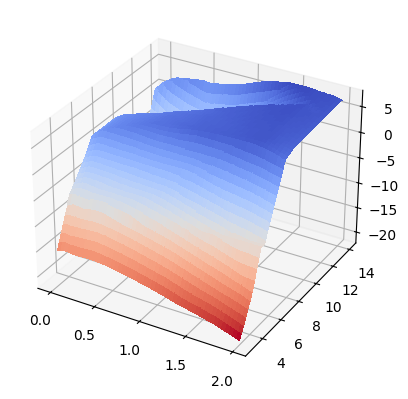

In [7]:
from tqdm import tqdm

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# plt.rcParams['font.family'] = 'Times New Roman'
dx = 0.01
dy = 0.01
min_x = 0
max_x = 2
min_y = 3
max_y = 14
x = np.arange(min_x, max_x, dx)
y = np.arange(min_y, max_y, dy)
X, Y = np.meshgrid(x, y)
size_x = len(x)
size_y = len(y)
V = np.zeros((X.shape))

car1_x = 0.5
car1_y = 13
car1_vy = 1.2
ego_v = 1.6
ego_theta = np.pi/2
car2_x = 1.5
car2_y = 6
car2_vy = 1.2

for ii in tqdm(range(V.shape[0])):
    for jj in range(V.shape[1]):
        tmp_point = torch.tensor([
            car1_x, car1_y, car1_vy, 
            X[ii,jj], Y[ii,jj], ego_v, ego_theta,
            car2_x, car2_y, car2_vy
            ])
        V[ii,jj] = evaluate_V( tmp_point )
        
surf = ax.plot_surface(X, Y, V, cmap=cm.coolwarm_r,
                        linewidth=0, antialiased=False)

In [8]:
binary_pure_V = np.zeros(V.shape)
binary_pure_V[V > 0] = 1
X_pure = X
Y_pure = Y 

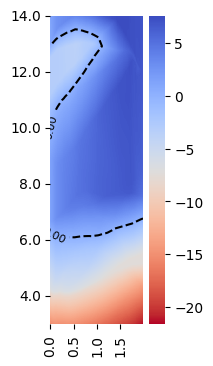

In [9]:
import seaborn as sns

x_interval = 50
y_interval = 200

fig, ax = plt.subplots(figsize=(1.5, 4))
V_flipped = np.flipud(V)
sns.heatmap(V_flipped, annot=False, cmap=cm.coolwarm_r, ax=ax,
            xticklabels=np.round(x[::x_interval], 2),
            yticklabels=np.round(y[::-y_interval], 1))
x_ticks = np.arange(0, len(x), x_interval)
y_ticks = np.arange(0, len(y), y_interval)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

ax.set_xticklabels(np.round(x[::x_interval], 2))
ax.set_yticklabels(np.round(y[::-y_interval]+dy, 1))

contours = ax.contour((X-min_x)*100, (Y-min_y)*100, V_flipped, levels=[0], colors='black', linestyles='dashed')
ax.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()


In [10]:
"""
success rate is computed by recording the number of initial states that can be maintained within the target set for 50 steps
"""
from LCRL.data import Batch
from tqdm import tqdm

def find_a(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy(tmp_batch, model = "actor_old").act
    act = policy.map_action(tmp).cpu().detach().numpy().flatten()
    return act

def evaluate_V(state):
    tmp_obs = np.array(state).reshape(1,-1)
    tmp_batch = Batch(obs = tmp_obs, info = Batch())
    tmp = policy.critic_old(tmp_batch.obs, policy(tmp_batch, model="actor_old").act)
    return tmp.cpu().detach().numpy().flatten()

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np
import math

n_dim = env.observation_space.shape[0]
def roll_out_traj(env, state, horizon, verbose = False):
    n_dim = env.observation_space.shape[0]
    state_traj = np.zeros((n_dim, horizon+1))
    
    state_traj[:,0] = state
    env.reset(initial_state = state)
    for t in range(horizon):
        action = find_a(state_traj[:,t])
        rand_disturbance = np.random.uniform(low = -1, high = 1, size = (2,))
        action = np.array([action[0], action[1], rand_disturbance[0], rand_disturbance[1]])
        tmp, rew, _, _, info = env.step(action)
        
        state_traj[:,t+1] = tmp
        if rew > 0 and t<=horizon-2:
            if t>1 and verbose:
                print("success at time = {}!".format(t))
            return state_traj[:,:t+1], True

        if info["constraint"] < 0:
            print("constraint violated!") if verbose else None
            return state_traj[:,:t+1], False
            break
        
    return state_traj, False

num_samples = 100
sampled_states = np.zeros((n_dim,num_samples))
num_success = 0
horizon = 50
list_of_failure_states = []
list_of_success_states = []
list_of_sampled_states = []
high = [1, 18, 2, 
        2, 18, 2, np.pi*3/4,
        2, 8, 1]
low  = [0, 8, 0.5,
        0, 2, 0.5, np.pi/4,
        1.5, 2, 0.5]
# high = envs.initial_condition_high
# low = envs.initial_condition_low
for ii in tqdm(range(num_samples)):
    sampled_initial_state = np.random.uniform(low = low, high = high)
    tmp = envs.reset(initial_state = sampled_initial_state)
    sampled_states[:,ii] = tmp[0]
    while evaluate_V(sampled_states[:,ii]) < 0:
        sampled_initial_state = np.random.uniform(low = low, high = high)
        tmp = envs.reset(initial_state = sampled_initial_state)
        sampled_states[:,ii] = tmp[0]
    # import pdb; pdb.set_trace()
    list_of_sampled_states.append(sampled_initial_state)
    traj, success = roll_out_traj(envs, sampled_states[:,ii], horizon, verbose = True)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(sampled_states[:,ii])
    else:
        list_of_failure_states.append(sampled_states[:,ii])
        continue
num_success/num_samples

  0%|          | 0/100 [00:00<?, ?it/s]/home/jingqili/miniconda3/envs/lcrl/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:188: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
 35%|███▌      | 35/100 [00:00<00:00, 348.82it/s]

success at time = 2!
success at time = 2!
success at time = 9!
success at time = 8!
success at time = 16!
success at time = 3!
success at time = 3!
success at time = 4!
success at time = 5!
success at time = 5!
success at time = 3!
success at time = 3!
success at time = 2!
success at time = 7!
success at time = 6!
success at time = 4!
success at time = 6!
success at time = 7!
success at time = 11!
success at time = 5!
success at time = 5!
success at time = 12!
success at time = 6!
success at time = 2!
success at time = 2!
success at time = 7!
success at time = 5!
success at time = 6!
success at time = 3!
success at time = 12!
success at time = 8!
success at time = 8!
success at time = 2!
success at time = 2!
success at time = 2!
success at time = 12!
success at time = 6!
success at time = 6!
success at time = 6!


100%|██████████| 100/100 [00:00<00:00, 340.59it/s]

success at time = 13!
success at time = 6!
success at time = 13!
success at time = 3!
success at time = 2!
success at time = 3!
success at time = 10!
success at time = 7!
success at time = 2!
success at time = 5!
success at time = 6!
success at time = 10!
success at time = 7!
success at time = 5!
success at time = 2!
success at time = 2!
success at time = 6!
success at time = 11!


1.0

In [11]:
# save the list of sampled states, we will use them in the notebook "highway_post_training_DDPG_evaluation_new.ipynb" to evaluate the learned policy there on this set of initial states
import pickle
with open("list_of_initial_states_highway_from_classical_reachability_value_function_learning.pkl", "wb") as f:
    pickle.dump(list_of_sampled_states, f)

In [12]:
# Test how the learned policy performs on the sampled initial states from highway_post_training_DDPG_evaluation_new.ipynb
# NOTE! We assume the list_of_initial_states_highway_from_new_reachability_value_function_learning.pkl is stored in the current directory, which can be obtained from highway_post_training_DDPG_evaluation_new.ipynb
import pickle
with open("list_of_initial_states_highway_from_new_reachability_value_function_learning.pkl", "rb") as f:
    list_of_initial_sampled_states = pickle.load(f)
num_samples = len(list_of_initial_sampled_states)
list_of_success_states = []
list_of_failure_states = []
num_success = 0
for ii in tqdm(range(num_samples)):
    tmp = envs.reset(initial_state = sampled_initial_state)
    traj, success = roll_out_traj(envs, list_of_initial_sampled_states[ii], horizon, verbose = True)
    if success==True :
        num_success = num_success + 1
        list_of_success_states.append(list_of_initial_sampled_states[ii])
    else:
        list_of_failure_states.append(list_of_initial_sampled_states[ii])
        continue
num_success/num_samples

100%|██████████| 100/100 [00:00<00:00, 517.29it/s]

success at time = 17!
success at time = 43!
success at time = 24!
success at time = 3!
success at time = 5!
success at time = 9!
success at time = 6!
success at time = 21!
success at time = 4!
success at time = 3!
success at time = 2!
constraint violated!
success at time = 4!
success at time = 15!
constraint violated!
success at time = 2!
success at time = 7!
success at time = 10!
success at time = 9!
success at time = 27!
success at time = 9!
success at time = 8!
success at time = 7!
success at time = 10!
success at time = 8!
success at time = 2!
success at time = 7!
success at time = 24!
success at time = 16!
success at time = 5!
success at time = 6!
success at time = 3!
success at time = 12!
success at time = 13!
success at time = 3!
success at time = 8!
success at time = 17!
success at time = 22!
success at time = 6!
success at time = 9!
success at time = 3!
success at time = 13!
success at time = 6!
success at time = 6!
success at time = 3!
success at time = 3!
constraint violated

0.96

success at time = 24!
success:  True


100%|██████████| 220/220 [00:00<00:00, 861.80it/s]
/tmp/ipykernel_21486/457420689.py:50: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1], colors = "#80A8D6", alpha = 0.8,
100%|██████████| 25/25 [00:00<00:00, 73.39it/s]


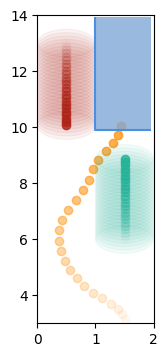

In [20]:
# draw animation of a rollout trajectory
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib
from tqdm import tqdm
FFMpegWriter = manimation.writers['ffmpeg']
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'))
def target_set(env, X, Y, tmp_point = np.zeros(10)):
    reward = np.zeros((X.shape))
    for ii in tqdm(range(reward.shape[0])):
        for jj in range(reward.shape[1]):
            tmp_point[3], tmp_point[4] = X[ii,jj], Y[ii,jj]
            env.reset(initial_state = tmp_point)
            reward[ii,jj] = 1 if env.step([0,0,0,0,0,0])[1]>=0 else 0
    return reward
initial_state = np.array([0.7, 13, 1.,
                        1.7, 2, 1., np.pi/2,
                        1.7, 6, 1.])


initial_state = np.array([
    car1_x, car1_y, car1_vy,
    1.5, 3.0, ego_v, ego_theta,
    car2_x, car2_y, car2_vy
])
horizon = 200
traj, success = roll_out_traj(env, initial_state, horizon, verbose=True)
print("success: ", success)
fig, ax = plt.subplots(figsize=(1.5, 4))


# create an alpha list from 0.2 to 1
alpha_list = np.linspace(0.01, 0.8, traj.shape[1])
# reverse the alpha list
# reverse_alpha_list = alpha_list[::-1]
ax.set_xlim(( min_x, max_x))
ax.set_ylim((min_y, max_y))
# how can I make the previous frame disappear?
for j in tqdm(range(traj.shape[1])):
    ax.scatter(traj[0,j], traj[1,j], color=color_list[4], label = "car 1", alpha = alpha_list[j])
    ax.scatter(traj[3,j], traj[4,j], color=color_list[0], label = "Ego", alpha = alpha_list[j])
    ax.scatter(traj[7,j], traj[8,j], color=color_list[7], label = "car 3", alpha = alpha_list[j])
    ax.add_patch(plt.Circle((traj[0,j], traj[1,j]), 0.5, color=color_list[4], alpha = 0.05))
    ax.add_patch(plt.Circle((traj[7,j], traj[8,j]), 0.5, color=color_list[7], alpha = 0.05))
    if j == traj.shape[1]-1:
        x = np.arange(min_x, max_x, 0.05)
        y = np.arange(min_y, max_y, 0.05)
        X, Y = np.meshgrid(x, y)
        reward = target_set(envs, X, Y, traj[:,j])
        plt.contourf(X,Y,reward, levels=[1 - 1e-6, 1], colors = "#80A8D6", alpha = 0.8, 
                    label = "target set"
                    # hatches=['//']
                    )
        plt.contour(X,Y,reward, levels=[1 - 1e-6], colors = color_list[8])


